New:
 - Additional D* with multiple pions sample

In [1]:
card_name = 'v7'

In [2]:
fit_real_data = True
category = 'low'
SM_RDst = 0.26
fastRun = False

# Import

In [3]:
import sys, os, pickle
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
import itertools
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleAddTkMassHad, plot_SingleAddTkMassVis
from progressBar import ProgressBar
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [5]:
cat = categories[category]

# Define binning

In [6]:
binning = {
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.8, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.2, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
    ],
    'Est_mu'  : [
        array('d', [0.3] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.3, 2.500],
        [20, 0.3, 2.500],
    ],
    'tkMassHad_0' : [30, 2.13, 2.73],
    'tkMassVis_0' : [25, 2.7, 5.3]
}
if fit_real_data:
    binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])
else:
    binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])

# Load the datasets

In [7]:
#They all have to be produced with the same pileup
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'Hc' : DSetLoader('B0_DmstHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_DmstPi0MuNu_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
dSet = {}
dSetTkSide = {}
for n, s in MCsample.iteritems():
    dSet[n] = rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name))
    dSetTkSide[n] = rtnp.root2array(s.skimmed_dir + '/{}_skip17_corr.root'.format(cat.name))

In [8]:
if fit_real_data:
    creation_date = '200416'
    locRD = '../data/cmsRD/skimmed/B2DstMu_{}_{}'.format(creation_date, cat.name)
    dSet['data'] = rtnp.root2array(locRD + '_corr.root')
    dSetTkSide['data'] = rtnp.root2array(locRD + '_skip17_corr.root')
    dataDir = '../data/cmsRD'
    datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
    lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
    CMS_lumi.integrated_lumi = lumi_tot
else:
    expectedLumi = {'low':6., 'mid':20., 'high':26., 'single':6.} #fb^-1
    lumi_tot = expectedLumi[category]

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


# Load all the calibrations

Pileup

In [9]:
loc = '../data/cmsRD/ParkingBPH{}/Run2018D-05May2019promptD-v1_RDntuplizer_PrescaleVertices_200421_CAND.root'
fAuxPileupRD = []

hPileupTarget = None

for i in range(2, 6):
    fAuxPileupRD.append(rt.TFile.Open(loc.format(i), 'READ'))
    if hPileupTarget is None:
        hPileupTarget = fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg).Clone()
    else:
        hPileupTarget.Add(fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg))

hPileupTarget.Scale(1./hPileupTarget.Integral())

fAuxPileupMC = rt.TFile.Open(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), 'READ')
hPileupGen = fAuxPileupMC.Get('hAllNvtx')
hPileupGen.Scale(1./hPileupGen.Integral())

weights = np.ones(hPileupGen.GetNbinsX())
s = 0
for i in range(weights.shape[0]):
    if hPileupGen.GetBinContent(i+1) == 0:
        continue
    weights[i] = hPileupTarget.GetBinContent(i+1)/hPileupGen.GetBinContent(i+1)
    s += hPileupGen.GetBinContent(i+1) * weights[i]

weightsPileupMC = weights/s

for f in fAuxPileupRD + [fAuxPileupMC]:
    f.Close()

def getPileupWeights(ds, selection=None):
    x = ds['N_vtx']
    if not selection is None:
        x = x[selection]
    return weightsPileupMC[x.astype(np.int)]

Total norm pre-scale

In [10]:
r = np.zeros((3,2))
for i, fn in enumerate(glob('../data/calibration/totalRate/ratioB02JPsiKst_*.txt')):
    with open(fn, 'r') as faux:
        aux = faux.readlines()[0][:-1].split(' ')
        r[i] = [float(aux[0]), float(aux[1])]
s2 = np.square(r[:,1])
num = np.sum(r[:,0]/s2)
den = np.sum(1./s2)
RDoMC_normRatio = [num/den, np.sqrt(1/den)]
print 'Expected ratio between RD and MC norm: {:.3f} +/- {:.3f}'.format(RDoMC_normRatio[0], RDoMC_normRatio[1])

Expected ratio between RD and MC norm: 2.632 +/- 0.063


Branching fraction

In [11]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

Trigger scale factor

In [12]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

In [13]:
def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    if not fastRun:
        ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
        ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
        etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
        x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
        if not selection is None:
            x = x[selection]
        for i, (pt, eta, ip) in enumerate(x):
            ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
            iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
            iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
            trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
            ib = hTriggerSF.GetBin(ix, iy, iz)
            trgSFUnc[i] = hTriggerSF.GetBinError(ib)
            if trgSF[i] == 0:
                print pt, ip, np.abs(eta)
                raise
    # Divide them for the weight so later you can simply multiply back to get the value
    up = 1 + trgSFUnc/trgSF
    down = 1 - trgSFUnc/trgSF
    return trgSF, up, down

Muon ID scale factors

In [14]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

In [15]:
def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    if not fastRun:
        ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
        etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
        x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
        if not selection is None:
            x = x[selection]
        for i, (pt, eta) in enumerate(x):
            ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
            if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
            iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
            muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
            muonSFUnc[i] = hMuonIDSF.GetBinError(hMuonIDSF.GetBin(ix, iy))
            if muonSF[i] == 0:
                print pt, eta
                print ix, iy
                raise
    up = 1 + muonSFUnc/muonSF
    down = 1 - muonSFUnc/muonSF
    return muonSF, up, down

B transverse momentum calibration

In [16]:
aux = 'Low' if category == 'single' else cat.name
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(aux))

In [17]:
def computeB0pTweights(ds):
    # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
    w = cal_pT.f['C'](ds['MC_B_pt'])
    if np.sum(w==0):
        print np.sum(w==0)
        raise
    up = cal_pT.f['Up'](ds['MC_B_pt'])/w
    down = cal_pT.f['Down'](ds['MC_B_pt'])/w
    return w, up, down

# Create MC histograms

### Signal region

In [18]:
histo = {}
for n, ds in dSet.iteritems():
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.1f}k'.format(1e-3*nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = getPileupWeights(ds)
    print 'Including trigger corrections'
    weights['trgSF'], wVar['trgSFUp'], wVar['trgSFDown'] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'Hc','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
        print 'Average weight: {:.3f}'.format(np.average(weights['B0pT']))
    
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'R1', 'R2', 'RhoSq']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + nPar + var]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): weightsCentral *= w
    print 'N tot expected (after weights): {:.1f}k'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected)
    wVar[''] = np.ones_like(weightsCentral)
    
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            if not cat_name in histo.keys():
                histo[cat_name] = {}
            
            for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo[cat_name][h_name] = create_TH1D(
                                                      ds[var][sel_q2], 
                                                      name=h_name, title=h_name, 
                                                      binning=binning[var][i_q2], 
                                                      opt='underflow,overflow',
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )


-----------> tau <-------------
N tot selected: 28.3k
N tot expected (before weights): 6.0k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.058
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 6.1k

-----------> DstPipPi0 <-------------
N tot selected: 14.5k
N tot expected (before weights): 0.2k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Computing total weights
N tot expected (after weights): 0.2k

-----------> DstPi0 <-------------
N tot selected: 36.1k
N tot expected (before weights): 3.8k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.039
Computing total weights
N tot expected (after weights): 3.9k

-----------> mu <-------------
N tot selected: 230.3k
N tot expected (before weights): 118.5k
Including pileup reweighting
Incl

### Single track side

In [19]:
def selectionSingleAddTkMassHad(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] > 0)
    return np.logical_and(np.abs(ds['tkMassHad_0'] - 2.43) < 0.3, sel)

def selectionSingleAddTkMassVis(ds):
    sel = np.logical_and(ds['tkCharge_0']*ds['tkCharge_1'] < 0, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['tkMassVis12'] < 5.3, sel)
#     sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] < 0)
    return sel

In [20]:
histo['SingleAddTkMassHad'] = {}
histo['SingleAddTkMassVis'] = {}

for n, ds in dSetTkSide.iteritems():
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = getPileupWeights(ds)
    print 'Including trigger corrections'
    weights['trgSF'], wVar['trgSFUp'], wVar['trgSFDown'] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'Hc','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
        print 'Average weight: {:.3f}'.format(np.average(weights['B0pT']))
    
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'R1', 'R2', 'RhoSq']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + nPar + var]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): weightsCentral *= w
    wVar[''] = np.ones_like(weightsCentral)
    
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], 
                  decayBR[n], 
                  sMC.effCand['effCAND'], 
                  sMC.getSkimEff(cat.name+'_skip17_corr'),
                 ]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    
    selMassHad = selectionSingleAddTkMassHad(ds)
    nTotSelMassHad = float(np.sum(selMassHad))
    print 'N tot selected Mass Had: {:.0f}'.format(nTotSelMassHad)
    nTotExpMassHad = nTotExp * nTotSelMassHad / selMassHad.shape[0]
    print 'N tot expected Mass Had (before weights): {:.0f}'.format(nTotExpMassHad)
    nAux = nTotExpMassHad*np.sum(weightsCentral[selMassHad])/nTotSelMassHad
    print 'N tot expected Mass Had (after weights): {:.0f}'.format(nAux)
    scaleMassHad = nTotExpMassHad/nTotSelMassHad
    
    selMassVis = selectionSingleAddTkMassVis(ds)
    nTotSelMassVis = float(np.sum(selMassVis))
    print 'N tot selected Mass Vis: {:.0f}'.format(nTotSelMassVis)
    nTotExpMassVis = nTotExp * nTotSelMassVis / selMassVis.shape[0]
    print 'N tot expected Mass Vis (before weights): {:.0f}'.format(nTotExpMassVis)
    nAux = nTotExpMassVis*np.sum(weightsCentral[selMassVis])/nTotSelMassVis
    print 'N tot expected Mass Vis (after weights): {:.0f}'.format(nAux)
    scaleMassVis = nTotExpMassVis/nTotSelMassVis
    
            
    for name_wVar, v_wVar in wVar.iteritems():
        h_name = n
        if not name_wVar == '':
            h_name += '__' + name_wVar
        w = weightsCentral*v_wVar
        histo['SingleAddTkMassHad'][h_name] = create_TH1D(
                                              ds['tkMassHad_0'][selMassHad], 
                                              name=h_name, title=h_name, 
                                              binning=binning['tkMassHad_0'],
                                              opt='underflow,overflow',
                                              weights=w[selMassHad], scale_histo=scaleMassHad,
                                              )
        histo['SingleAddTkMassVis'][h_name] = create_TH1D(
                                              ds['tkMassVis12'][selMassVis], 
                                              name=h_name, title=h_name, 
                                              binning=binning['tkMassVis_0'],
                                              opt='underflow,overflow',
                                              weights=w[selMassVis], scale_histo=scaleMassVis,
                                              )


-----------> tau <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.058
Including FF corrections (Hammer)
Computing total weights
N tot selected Mass Had: 1040
N tot expected Mass Had (before weights): 220
N tot expected Mass Had (after weights): 227
N tot selected Mass Vis: 79
N tot expected Mass Vis (before weights): 17
N tot expected Mass Vis (after weights): 19

-----------> DstPipPi0 <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Computing total weights
N tot selected Mass Had: 31099
N tot expected Mass Had (before weights): 461
N tot expected Mass Had (after weights): 454
N tot selected Mass Vis: 1408
N tot expected Mass Vis (before weights): 21
N tot expected Mass Vis (after weights): 21

-----------> DstPi0 <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 p

# Create (pseudo-)data histogram

In [21]:
if fit_real_data:
    ds = dSet['data']
    print 'N observed data: {:.1f}k'.format(1e-3*ds['q2'].shape[0])
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)     
            histo[cat_name]['data'] = create_TH1D(
                                                  ds[var][sel_q2], 
                                                  name='data_obs', title='Data Obs',
                                                  binning=binning[var][i_q2],
                                                  opt='underflow,overflow'
                                                 )
    ds = dSetTkSide['data']
    histo['SingleAddTkMassHad']['data'] = create_TH1D(
                                          ds['tkMassHad_0'][selectionSingleAddTkMassHad(ds)], 
                                          name='data_obs', title='Data Obs',
                                          binning=binning['tkMassHad_0'], 
                                          opt='underflow,overflow'
                                          )
    
    histo['SingleAddTkMassVis']['data'] = create_TH1D(
                                              ds['tkMassVis12'][selectionSingleAddTkMassVis(ds)], 
                                              name='data_obs', title='Data Obs',
                                              binning=binning['tkMassVis_0'],
                                              opt='underflow,overflow',
                                              )
else:
    for i_q2 in range(len(binning['q2'])-1):
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning[var][i_q2])
            h.Reset()
            for n, hMC in histo[cat_name].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
            h.Sumw2(0)
            for i in range(1, h.GetNbinsX()+1):
                h.SetBinContent(i, np.around(h.GetBinContent(i)))
            h.Sumw2()
            histo[cat_name]['data'] = h
            
    for var in ['Had', 'Vis']:
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', 
                        binning=binning['tkMass{}_0'.format(var)])
        h.Reset()
        for n, hMC in histo['SingleAddTkMass{}'.format(var)].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo['SingleAddTkMass{}'.format(var)]['data'] = h

N observed data: 162.7k


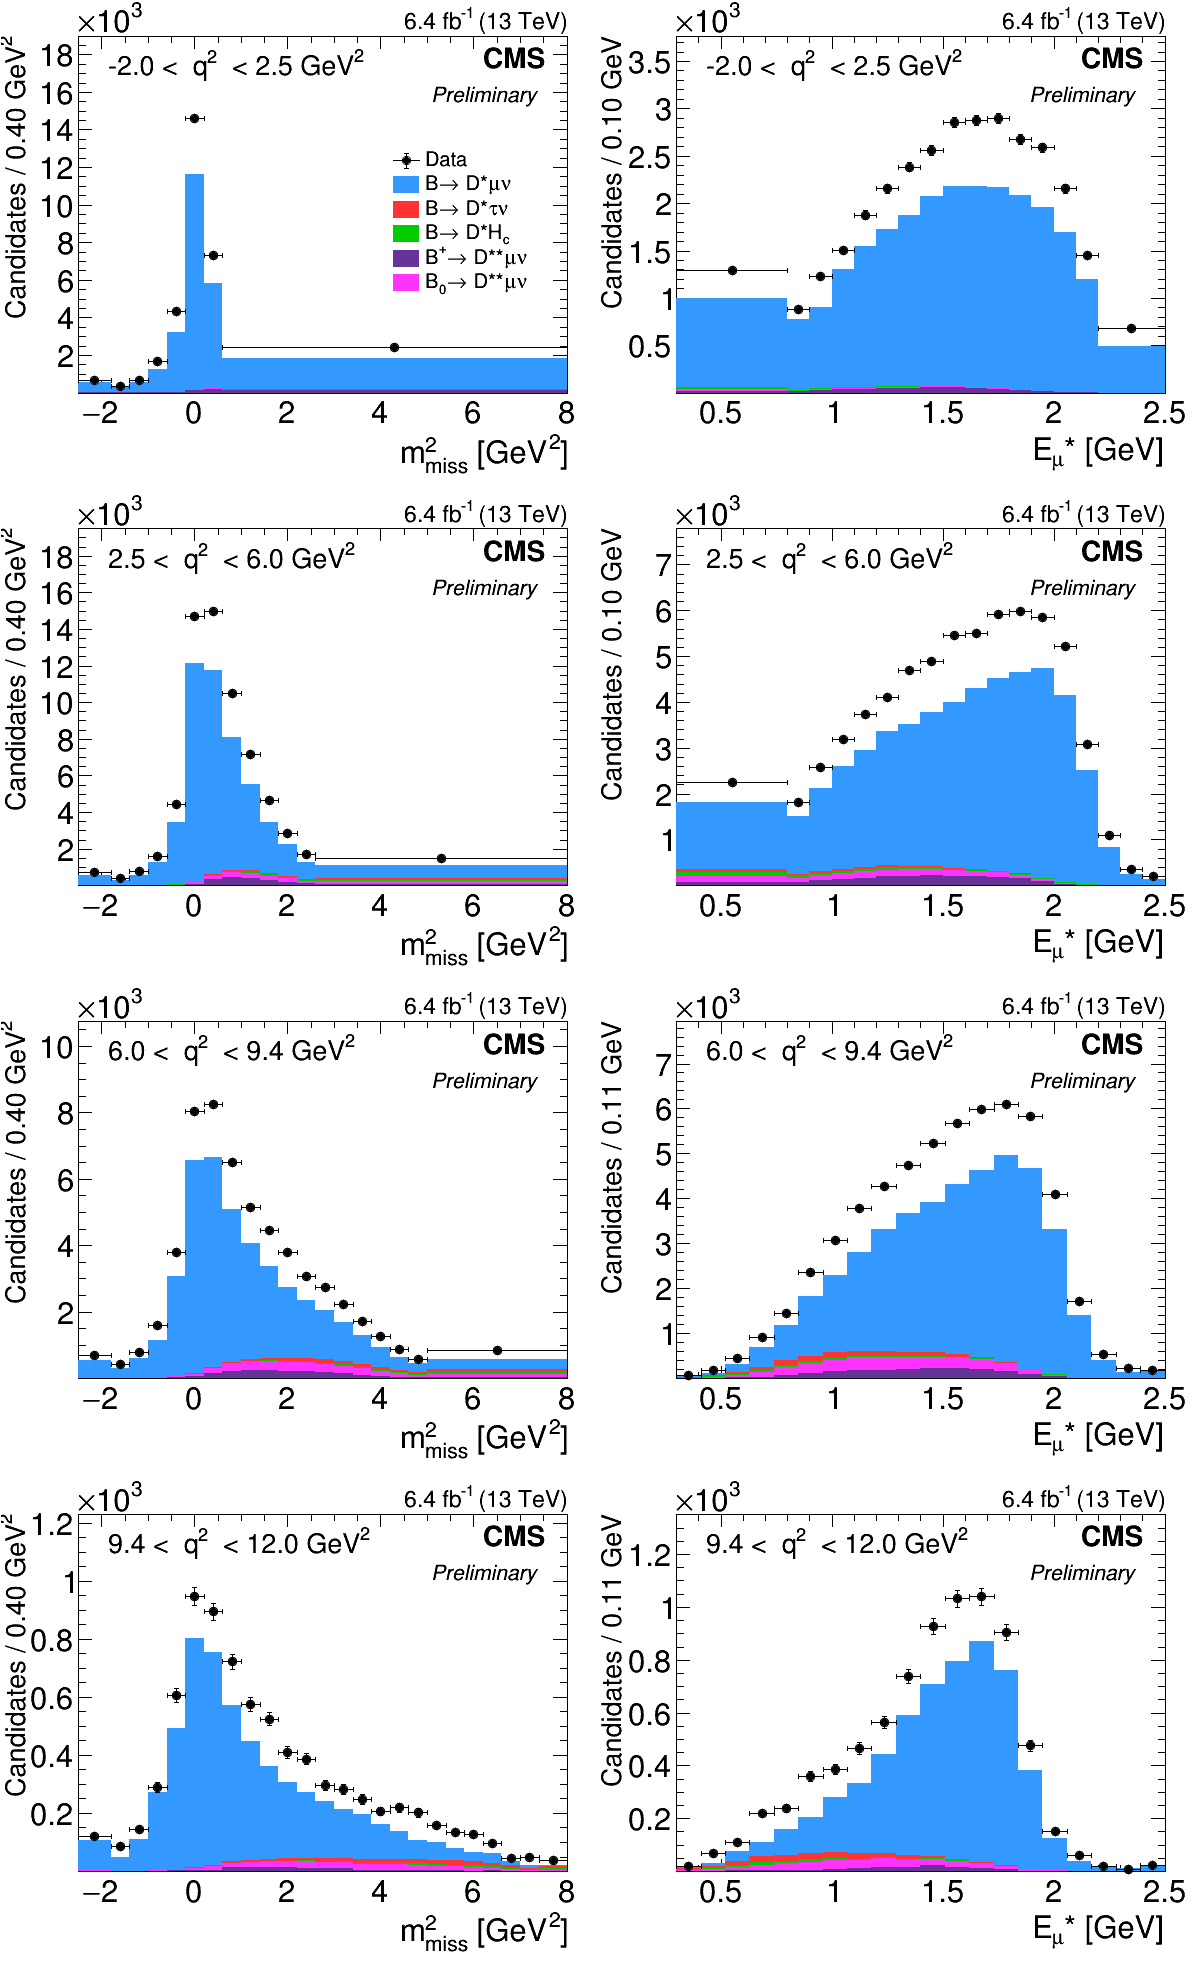

In [22]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {'tau': SM_RDst
            }

cSig = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic=scale_dic, min_y=1, logy=False)

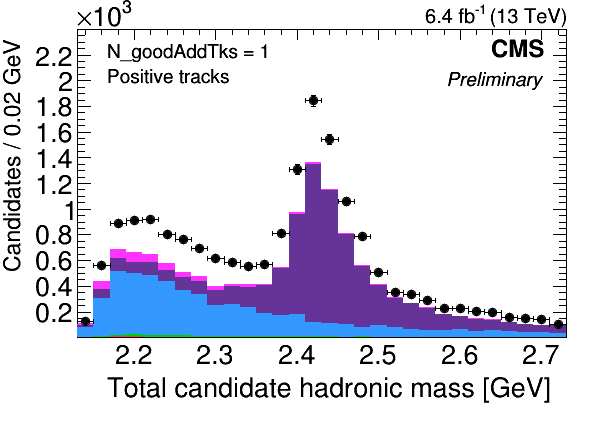

In [23]:
cHad = plot_SingleAddTkMassHad(CMS_lumi, histo, scale_dic=scale_dic, min_y=1, logy=False)

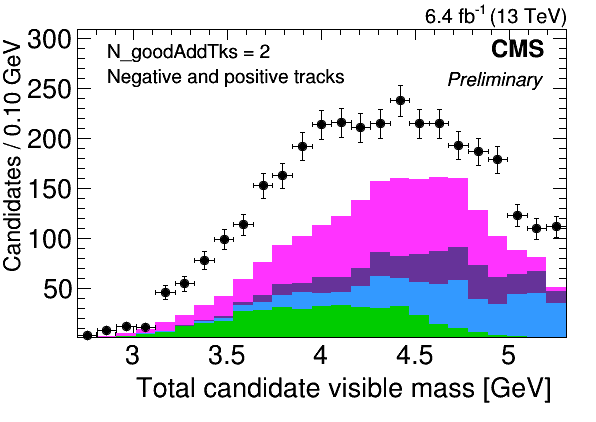

In [24]:
cVis = plot_SingleAddTkMassVis(CMS_lumi, histo, scale_dic=scale_dic, min_y=1, logy=False)

In [25]:
histo_file_dir = '../data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()
    
del dSet, dSetTkSide

# Write the card

In [26]:
sig_processes = ['tau', 'mu']
bkg_processes = ['Hc', 'DstPip', 'DstPipPi0', 'DstPi0', 'DstPipPim', 'DstPi0Pi0']
processes = sig_processes + bkg_processes
nProc = len(processes)
categories = np.sort([k for k in histo.keys()])
nCat = len(categories)

In [27]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [28]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '--------------------------------------------------------------\n'

In [29]:
# shape file location
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '--------------------------------------------------------------\n'

In [30]:
# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '--------------------------------------------------------------\n'

In [31]:
# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {:.2f}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '--------------------------------------------------------------\n'

### Systematic uncertainties

Scale systematics

In [32]:
#pp -> bb cros-section * luminosity
card += 'xsecpp2bbXlumi lnN' + ' 1.9'*nProc*nCat + '\n'

In [33]:
#Hadronization fraction of B0
aux = ''
for n in processes:
    if n in ['tau', 'mu', 'Hc', 'DstPi0', 'DstPipPim', 'DstPi0Pi0']: aux += ' 3'
    else: aux += ' -'
card += 'b2B0Had lnN' + aux*nCat + '\n'

In [34]:
#Hadronization fraction of B+
aux = ''
for n in processes:
    if n in ['DstPip', 'DstPipPi0']: aux += ' 3'
    else: aux += ' -'
card += 'b2BpHad lnN' + aux*nCat + '\n'

In [35]:
# Selection efficiencies
for n in processes:
    if n == 'tau': continue
    val = ' {:.2f}'.format(1+decayBR[n][1]/decayBR[n][0])
    aux = ''
    for nn in processes:
        if nn == n: aux += val
        else: aux += ' -'
    card += n + 'Br lnN' + aux*nCat + '\n'

In [36]:
# aux = ''
# for c in categories:
#     if not 'AddTk' in c:
#         aux += ' -'*nProc
#     else:
#         for p in processes:
#             if p == 'mu':
#                 aux += ' 3.'
#             else:
#                 aux += ' -'
# card += 'muAddTrak lnN' + aux + '\n'

In [37]:
card += '--------------------------------------------------------------\n'

Shape Systematics

In [38]:
card += 'trgSF shape' + ' 1.'*nProc*nCat + '\n'

In [39]:
card += 'muonIdSF shape' + ' 1.'*nProc*nCat + '\n'

In [40]:
# B0 pT spectrum
aux = ''
for p in processes:
    if p in ['tau', 'mu', 'Hc', 'DstPi0', 'DstPipPim', 'DstPi0Pi0']:
        aux += ' 1.'
    else:
        aux += ' -'
card += 'B0pT shape' + aux*nCat + '\n'

In [41]:
# Form Factors from Hammer
for n_pFF in ['R0', 'R1', 'R2', 'RhoSq']:
    aux = ''
    for p in processes:
        if p in ['tau', 'mu']:
            aux += ' 1.'
        else:
            aux += ' -'
    card += 'B2DstCLN{} shape'.format(n_pFF) + aux*nCat + '\n'

MC statistic systematics

In [42]:
card += '* autoMCStats 0 1 1\n'
card += '--------------------------------------------------------------\n'

Defining groups of systematics

In [43]:
# autoMCStats group = defined by default when using autoMCStats
aux_FF = ' '.join(['B2DstCLN'+n for n in ['R0', 'R1', 'R2', 'RhoSq']])
card += 'B2DstFF group = ' + aux_FF + '\n'

# card += 'normMC group = xsecpp2bbXlumi b2B0Had b2BpHad\n'
card += 'normMC group = xsecpp2bbXlumi b2B0Had b2BpHad\n'

card += 'knownBr group = ' + ' '.join([n+'Br' for n in processes if not n == 'tau']) + '\n'

card += 'allShape group = trgSF muonIdSF B0pT ' + aux_FF + '\n'

In [44]:
print card

imax *
jmax 7
kmax *
--------------------------------------------------------------
shapes * Est_mu_q2bin0 ../data/_root/histos4combine/v7_Est_mu_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin1 ../data/_root/histos4combine/v7_Est_mu_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin2 ../data/_root/histos4combine/v7_Est_mu_q2bin2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin3 ../data/_root/histos4combine/v7_Est_mu_q2bin3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin0 ../data/_root/histos4combine/v7_M2_miss_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin1 ../data/_root/histos4combine/v7_M2_miss_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin2 ../data/_root/histos4combine/v7_M2_miss_q2bin2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin3 ../data/_root/histos4combine/v7_M2_miss_q2bin3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * SingleAddTkMassHad ../data/_root/histos4combine/v7_SingleAd

In [45]:
fc.write(card)
fc.close()

### Create output directory

In [46]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

## Create the workspace

In [47]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
# cmd += ' --no-wrappers'
os.system(cmd)

0

Channel Est_mu_q2bin0 will use autoMCStats with settings: event-threshold=0, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binEst_mu_q2bin0
Poisson cut-off: 0
Bin        Contents        Error           Notes                         
0          1019.150654     27.665076       total sum                     
0          1357.000000     36.837481       Unweighted events, alpha=0.751032
  => Total parameter prop_binEst_mu_q2bin0_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          789.162573      23.967221       total sum                     
1          1084.000000     32.924155       Unweighted events, alpha=0.728010
  => Total parameter prop_binEst_mu_q2bin0_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
2          915.191784      25.103092       total sum                     
2          1329.000000     36.455452       Unweighted events, alpha=0.

Creating pdfs for individual modes (10): .    1.    2.    3.    4.    5.    6.    7.    8.    9.   10done.
Importing combined pdf model_s


### Run the Maximum Likelyhood fit

In [48]:
seedMLf = '6741'

In [49]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
cmd += ' --skipBOnlyFit'
cmd += ' --seed ' + seedMLf
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,5'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --skipBOnlyFit --seed 6741 -d cards/v7.root -D data_obs --setParameters r=0.26 --setParameterRanges r=0.001,5 -n v7 --out results/v7 --saveShapes --saveWithUncertainties --saveNormalizations --plots --verbose 1


0

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 6741
Turning on runtime-define MINIMIZER_analytic
 PDF CHECKING 
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes:  [SnapShot_ExtRefClone,forceGenBinned] 
  Address: 0x8b83640
  Clients: 
    (0x8f809f0,V-) RooSimultaneousOpt::model_s "model_s"
  Servers: 
    (0x8b84c10,V-) RooRealSumPdf::pdf_binEst_mu_q2bin0_nuis ""
    (0x93173c0,V-) RooProdPdf::pdfbins_binEst_mu_q2bin0 ""
    (0x8b5a5e0,V-) SimpleGaussianConstraint::xsecpp2bbXlumi_Pdf "xsecpp2bbXlumi_Pdf"
    (0x8b5fd20,V-) SimpleGaussianConstraint::b2B0Had_Pdf "b2B0Had_Pdf"
    (0x8b7fd60,V-) SimpleGaussianConstraint::b2BpHad_Pdf "b2BpHad_Pdf"
    (0x8cd5570,V-) SimpleGaussianConstraint::muBr_Pdf "muBr_Pdf"
    (0x8e06920,V-) SimpleGaussianConstraint::HcBr_Pdf "HcBr_Pdf"
    (0x8da3de0,V-) SimpleGaussianConst

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/cards/v7.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Error in <TList::Clear>: A list is accessing an object (0x934bf5c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x934c204) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x934c4ac) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x934c754) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x934c9fc) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x934cca4) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x934cf4c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x93

In [50]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.{}.root'.format(card_name, seedMLf))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)

R(D*) = 0.410 +0.071/-0.071 [17.3 %]


In [51]:
# Get post-fit shapes
f = rt.TFile.Open(glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0], 'READ')
fd = f.shapes_fit_s

histo_postfit = {}
for cat, h_dic in histo.iteritems():
    histo_postfit[cat] = {}
    for n, h in h_dic.iteritems():
        if '__' in n:
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if 'data' in n:
            h_fit = fd.Get(cat+'/total')
            h_data = h.Clone(h.GetName() + '_data')
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))     
            
            histo_postfit[cat]['total'] = h_post
            histo_postfit[cat][n] = h_data
        else:
            h_fit = fd.Get(cat+'/'+n)
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i)) 

            histo_postfit[cat][n] = h_post

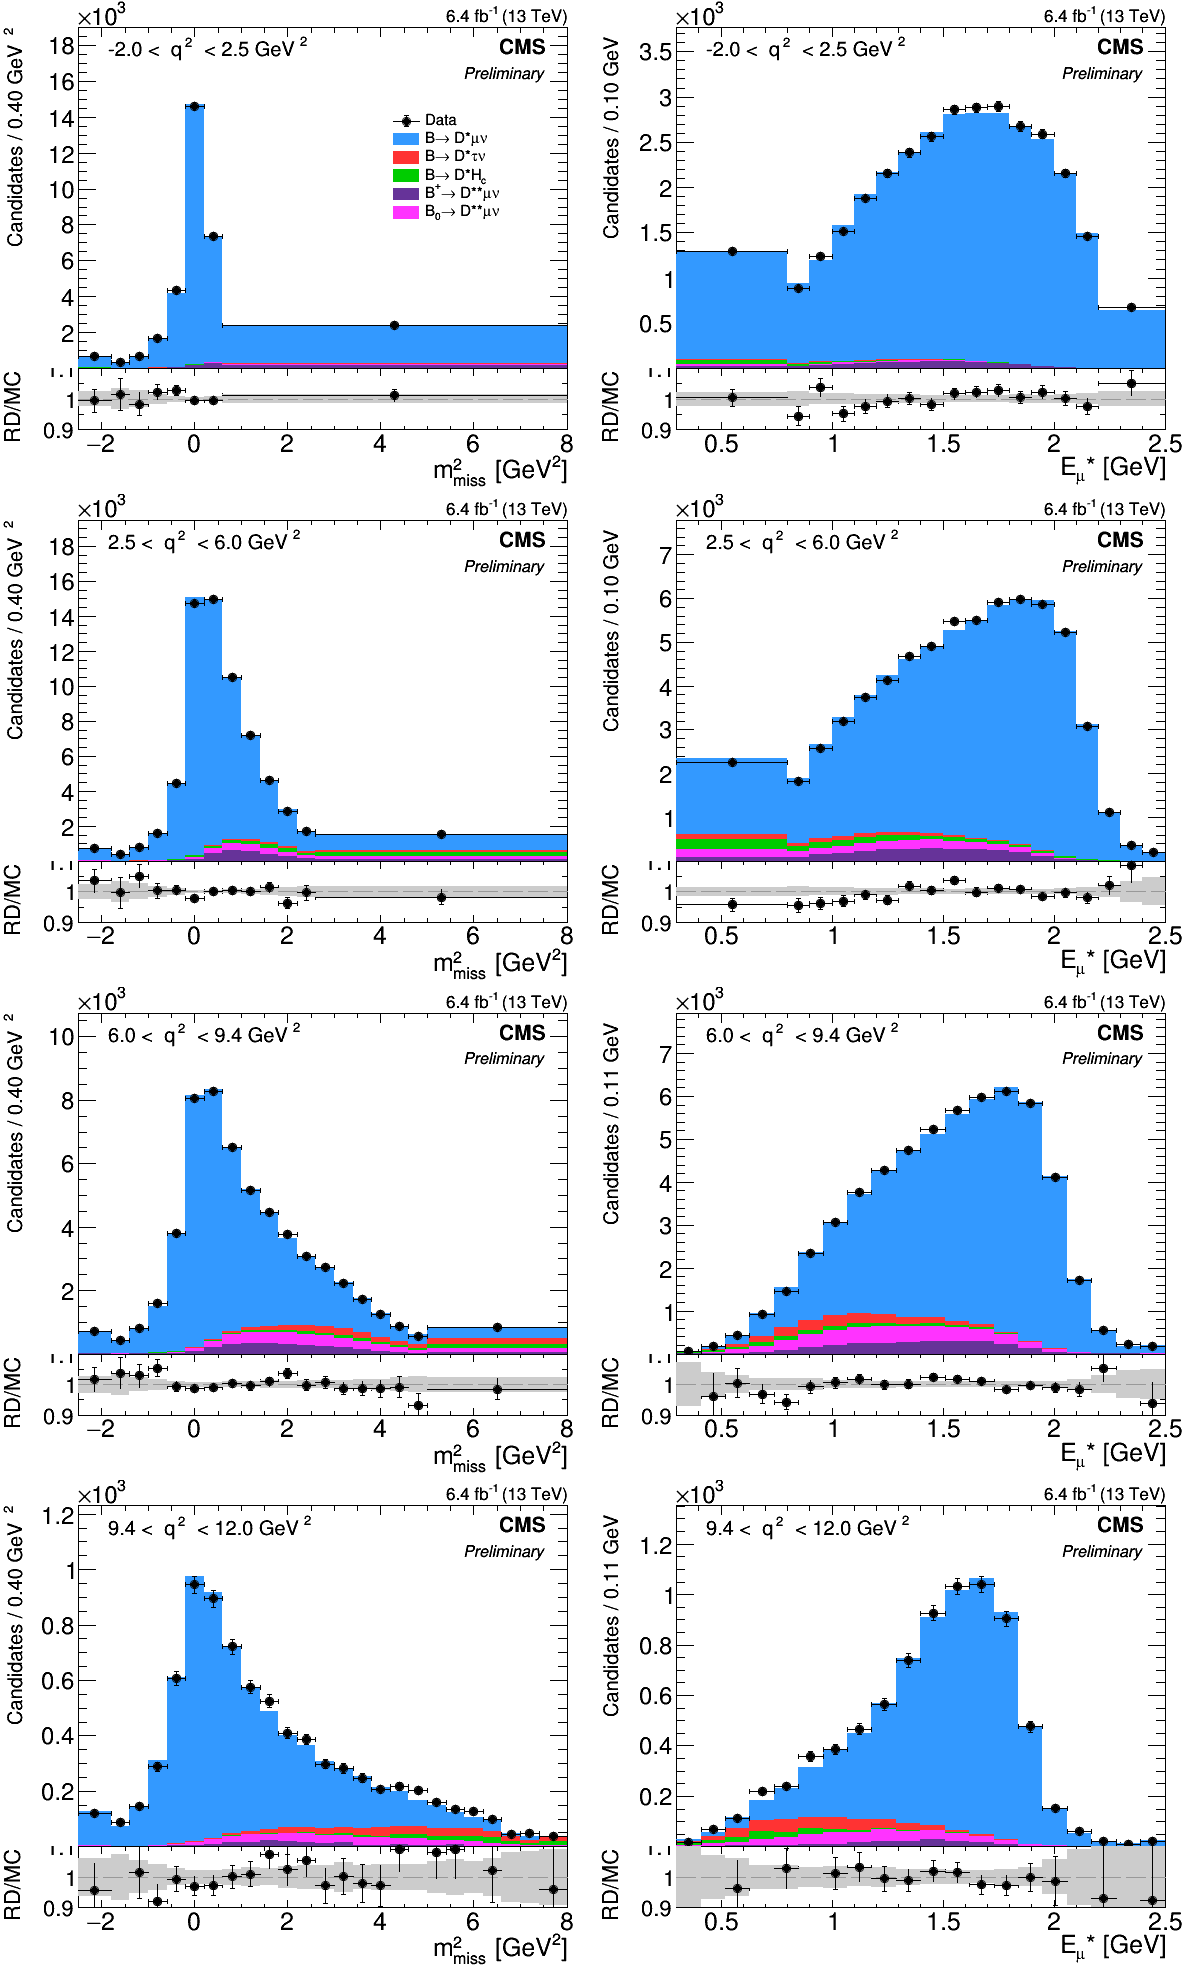

In [52]:
ccPostSig = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, scale_dic={}, draw_pulls=True, pulls_ylim=[0.9, 1.1])
ccPostSig.SaveAs('gridPlot_test.png')

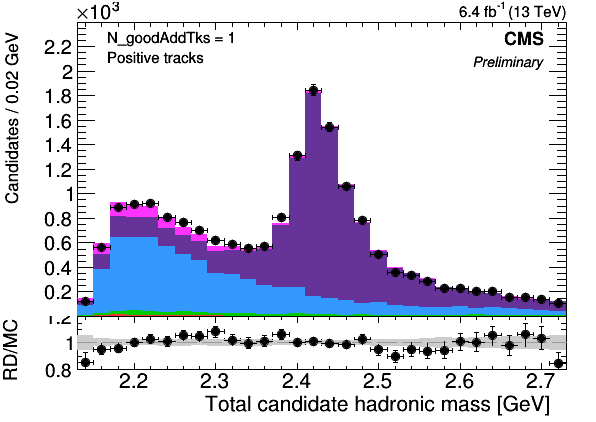

In [53]:
ccPostHad = plot_SingleAddTkMassHad(CMS_lumi, histo_postfit, scale_dic={}, draw_pulls=True, pulls_ylim=[0.8, 1.2])

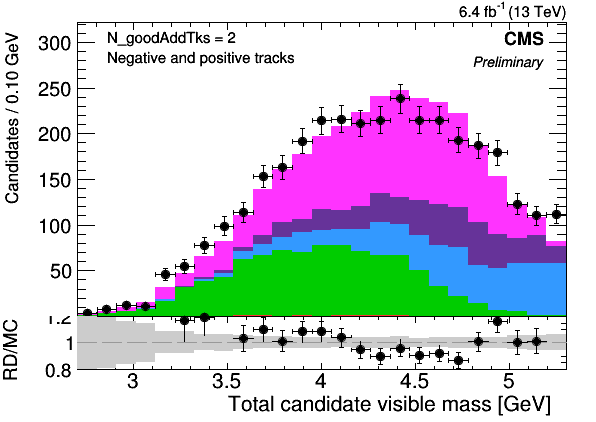

In [54]:
ccPostVis = plot_SingleAddTkMassVis(CMS_lumi, histo_postfit, scale_dic={}, draw_pulls=True, pulls_ylim=[0.8, 1.2])

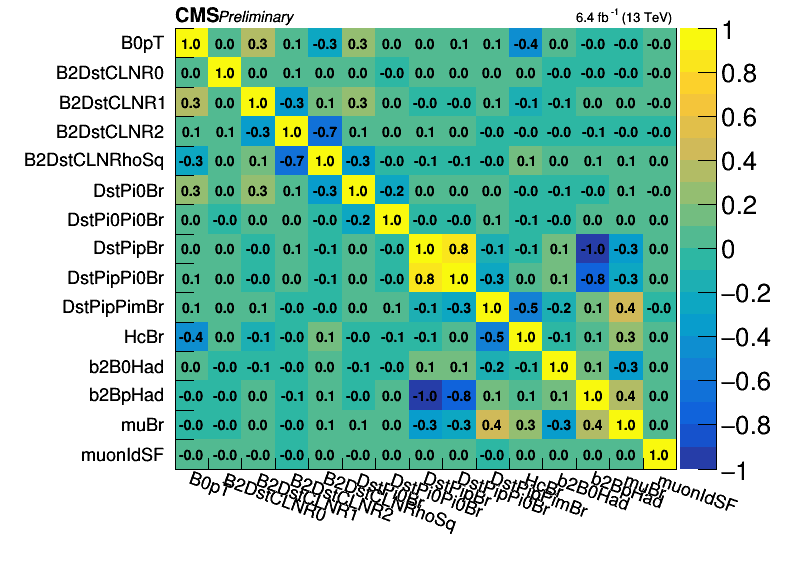

In [55]:
h2 = f.Get('covariance_fit_s')
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=15

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(1.3)
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], tag='tl', mL=0.22, mR=0.15, mB=0.18)

In [56]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0]
cmd += ' --skipFitB'
cmd += ' -g {}/nuisance_pull.root'.format(outdir)
print cmd
os.system(cmd)

python diffNuisances.py results/v7/fitDiagnosticsv7.root --skipFitB -g results/v7/nuisance_pull.root


0

diffNuisances run on results/v7/fitDiagnosticsv7.root, at 2020-04-30 02:33:57.697108 with the following options ... {'absolute_values': False, 'show_all_parameters': False, 'format': 'text', 'stol2': 0.5, 'pullDef': '', 'vtol': 0.3, 'stol': 0.1, 'plotfile': 'results/v7/nuisance_pull.root', 'skipFitB': True, 'vtol2': 2.0, 'poi': 'r'}

name                                              b-only fit            s+b fit         rho
B0pT                                          ! -0.04, 0.39!     ! -0.04, 0.39!       -0.38
B2DstCLNR0                                       -0.70, 0.98        -0.70, 0.98       -0.03
B2DstCLNR1                                       +0.18, 0.79        +0.18, 0.79       -0.02
B2DstCLNR2                                       -0.43, 0.71        -0.43, 0.71       -0.15
B2DstCLNRhoSq                                    -0.57, 0.68        -0.57, 0.68       +0.28
DstPi0Br                                         +0.13, 0.60        +0.13, 0.60       -0.73
DstPipBr            

In [57]:
if fastRun:
    raise

### Run likelyhood scan

In [58]:
def getUncertainty(name, verbose=True):
    f = ur.open(name)
    r_arr = f['limit']['r'].array()
    nll_arr = f['limit']['deltaNLL'].array()
    c = r_arr[0]
    r_u = r_arr[r_arr>r_arr[0]]
    nll_u = nll_arr[r_arr>r_arr[0]]
    f_u = interp1d(nll_u, r_u, 'quadratic')
    u = f_u(0.5)
    r_l = r_arr[r_arr<r_arr[0]]
    nll_l = nll_arr[r_arr<r_arr[0]]
    f_l = interp1d(nll_l, r_l, 'quadratic')
    l = f_l(0.5)
    if verbose:
        print '----------------------------------'
        print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)
        print 'Sigma = {:.3f}'.format((u-l)*0.5)
        print '----------------------------------\n'
    return c, c-l, u-c, (u-l)*0.5

combine -M MultiDimFit --algo grid --points=100 --robustFit 1 -d cards/v7.root -D data_obs --X-rtd MINIMIZER_analytic --rMin=0.0543 --rMax=0.7657 -n v7_nominal --verbose -1
----------------------------------
R(D*) = 0.410 +0.072/-0.071 [17.5 %]
Sigma = 0.072
----------------------------------



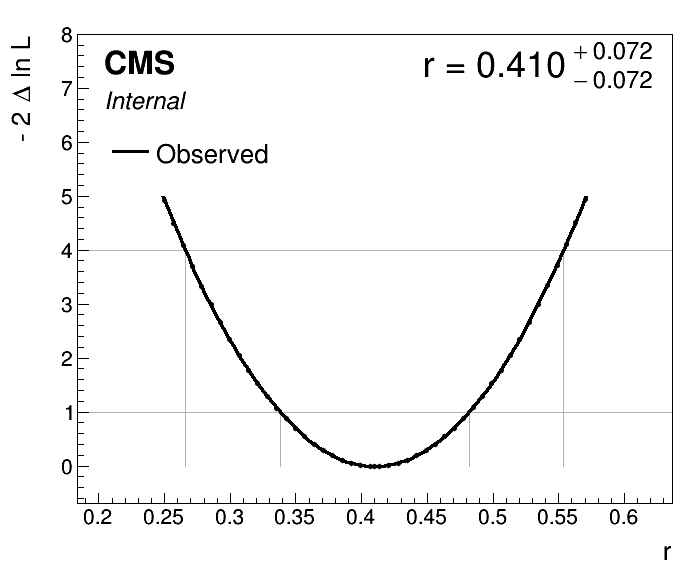

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.25 min (cpu), 0.25 min (real)
--------------------------------------
scan
--------------------------------------
[{'lo': 0.33794671665642567, 'hi': 0.4820542007077512, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2658114815136741, 'hi': 0.5539207223669353, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [59]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
res_nominal = getUncertainty('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [60]:
cmd = 'combine -M MultiDimFit --algo none'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo none --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d cards/v7.root -D data_obs --setParameters r=0.26 --setParameterRanges r=0.001,1 -n v7_bestfit --saveWorkspace --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.410
Done in 0.01 min (cpu), 0.01 min (real)


In [61]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats,allShape'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev7_bestfit.MultiDimFit.mH120.root -D data_obs --rMin=0.0543 --rMax=0.7657 -n v7_stat --snapshotName MultiDimFit --freezeNuisanceGroups=autoMCStats,allShape --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.06 min (cpu), 0.06 min (real)


In [62]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev7_bestfit.MultiDimFit.mH120.root -D data_obs --rMin=0.0543 --rMax=0.7657 -n v7_MCstat --snapshotName MultiDimFit --freezeNuisanceGroups=autoMCStats --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 0.16 min (cpu), 0.16 min (real)


plot1DScan.py higgsCombinev7_nominal.MultiDimFit.mH120.root --others "higgsCombinev7_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4" "higgsCombinev7_stat.MultiDimFit.mH120.root:Freeze all:2" --breakdown MCstat,syst,stat; mv scan.png scan_MCstat.png


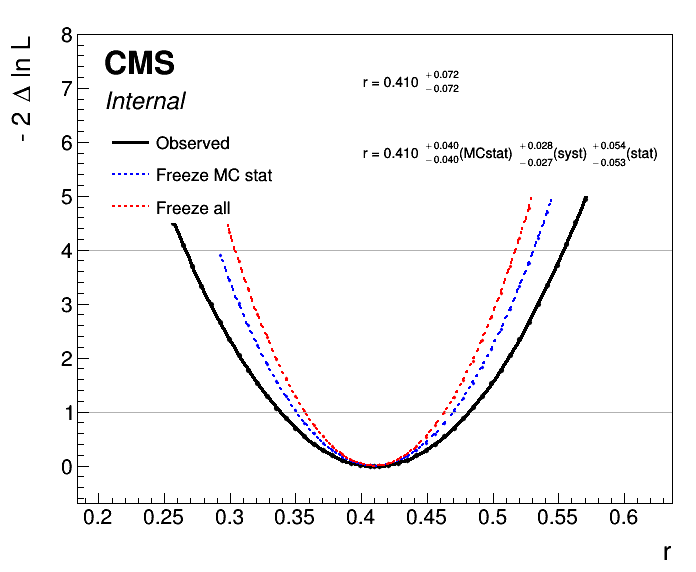

--------------------------------------
scan
--------------------------------------
[{'lo': 0.33794671665642567, 'hi': 0.4820542007077512, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2658114815136741, 'hi': 0.5539207223669353, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.350256323336157, 'hi': 0.47019013514421243, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.292618989944458, 'hi': 0.531239213533832, 'valid_hi': True, 'valid_lo': False}]
[{'lo': 0.3567444935389125, 'hi': 0.46359285529043254, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.3039184989561412, 'hi': 0.517384183107849, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [63]:
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown MCstat,syst,stat'
cmd += '; mv scan.png scan_MCstat.png'
print cmd
os.system(cmd)
display(Image(filename='scan_MCstat.png'))

In [64]:
os.system('mv higgsCombine*.root ' + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

### Run the impact plots

Fit first the POI

In [65]:
cmd = 'combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --verbose -1'
os.system(cmd);

Have POIs: ['r']
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.410   -0.071/+0.072 (68%)
Done in 0.05 min (cpu), 0.05 min (real)
>> combine -M MultiDimFit -n _initialFit_v7 --algo singles --redefineSignalPOIs r --robustFit 1 --X-rtd MINIMIZER_analytic -D data_obs --setParameterRanges r=0.001,1 --verbose -1 -m 120 -d cards/v7.root --setParameters r=0.26


 Perform a similar scan for each nuisance parameter

In [66]:
cmd = 'combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' --parallel 20'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combineTool.py -M Impacts --doFits -m 120 --robustFit 1 --X-rtd MINIMIZER_analytic --parallel 20 -d cards/v7.root -D data_obs -n v7 --verbose -1
Have POIs: ['r']
Have parameters: 211
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
 

Collect the results

In [67]:
cmd = 'combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

combineTool.py -M Impacts -o impacts.json -m 120 -d cards/v7.root -n v7
Have POIs: ['r']
Have parameters: 211


In [69]:
rename = {
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*#ell#nu)',
'B2DstCLNR1':'R_{1} (CLN B#rightarrow D*)',
'B2DstCLNR2':'R_{2} (CLN B#rightarrow D*)',
'B2DstCLNRhoSq':'#rho^{2} (CLN B#rightarrow D*)'
}

procName_dic = {
'mu'        : 'B_{0}#rightarrow D*#mu#nu',
'tau'       : 'B_{0}#rightarrow D*#tau#nu',
'Hc'        : 'B_{0}#rightarrow D*H_{c}',
'DstPip'    : 'B^{+}#rightarrow D*#pi^{+}#mu#nu',
'DstPipPi0' : 'B^{+}#rightarrow D*#pi^{+}#pi^{0}#mu#nu',
'DstPi0'    : 'B_{0}#rightarrow D*#pi^{0}#mu#nu',
'DstPipPim' : 'B_{0}#rightarrow D*#pi^{+}#pi^{-}#mu#nu',
'DstPi0Pi0' : 'B_{0}#rightarrow D*#pi^{0}#pi^{0}#mu#nu'
}

for n in processes:
    rename[n+'Br'] = 'Branching fraction ' + procName_dic[n]
json.dump(rename, open('rename.json', 'w'))

cmd = 'plotImpacts.py -i impacts.json -o impacts -t rename.json'
os.system(cmd)
IFrame("impacts.pdf", width=900, height=600)

>> Doing page 0, have 30 parameters
>> Doing page 1, have 30 parameters
>> Doing page 2, have 30 parameters
>> Doing page 3, have 30 parameters
>> Doing page 4, have 30 parameters
>> Doing page 5, have 30 parameters
>> Doing page 6, have 30 parameters
>> Doing page 7, have 1 parameters


Info in <TCanvas::Print>: pdf file ./impacts.pdf has been created using the current canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./imp

In [70]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv impacts.* {}/'.format(outdir))
os.system('mv rename.json {}/'.format(outdir))
os.system('mv combine_logger.out {}/'.format(outdir));

### Run the Goodness of fit test

Run the observed test stat value

In [71]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic'
# cmd += ' -d ' + card_location
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic -d results/v7/higgsCombinev7_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --bypassFrequentistFit -D data_obs -n Obs -t 0 -s -1 --setParameters r=0.26 --setParameterRanges r=0.001,1 --plots --verbose -1


0

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> Used OpenSSL to get a really random seed 438689410
Set Range of Parameter r To : (0.001,1)
Set Default Value of Parameter r To : 0.26
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters

 --- GoodnessOfFit --- 
Best fit test statistic: 418.386
Done in 0.01 min (cpu), 0.01 min (real)


Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v7/higgsCombinev7_bestfit.MultiDimFit.mH120.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
RooSimultaneousOpt: number of channel masks must equal number of channels


Run the test stat toy distribution

In [72]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic'
# cmd += ' -d ' + card_location
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 50'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic -d results/v7/higgsCombinev7_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --bypassFrequentistFit -D data_obs -n Toys -t 50 -s -1 --setParameters r=0.26 --setParameterRanges r=0.001,1 --plots --verbose -1


0

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> Used OpenSSL to get a really random seed 602402176
Set Range of Parameter r To : (0.001,1)
Set Default Value of Parameter r To : 0.26
Generate toy 1/50
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters

 --- GoodnessOfFit --- 
Best fit test statistic: 170.114
Done in 0.02 min (cpu), 0.02 min (real)
Generate toy 2/50
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisa

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/v7/higgsCombinev7_bestfit.MultiDimFit.mH120.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channel

Combine them to get the p-value

In [73]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]

p-value: 0.0%
0.0


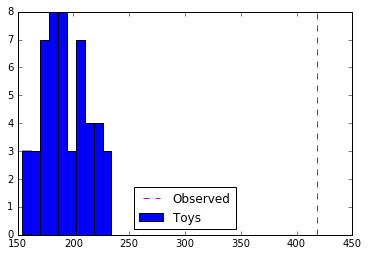

In [74]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

content, center, _ = plt.hist(s_toys, label='Toys')
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed')
plt.legend(loc='best')

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [75]:
os.system('mv *.root {}/'.format(outdir))

0